In [1]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
from fastdtw import dtw
import seaborn as sns
import matplotlib.pyplot as plt

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import variables as var
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(var)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, demographic_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols
from scripts.variables import df_names, df_mis, df_names_with_mis

id_columns.append('idx')


/opt/anaconda3/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)




DATAFRAME: v1_day
In df there are 1136 subjects.


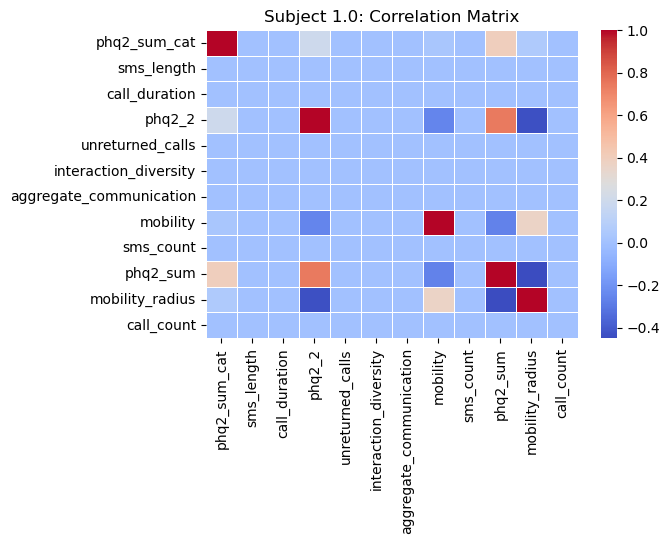

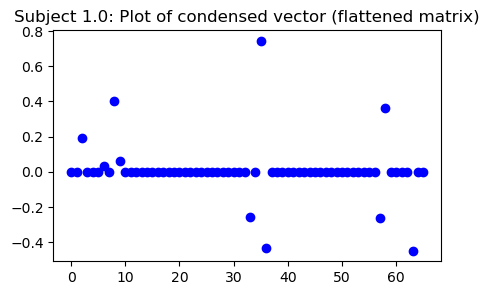

792 subs with symptom matrices
792 filled condensed arrays


DATAFRAME: v2_day
In df there are 975 subjects.


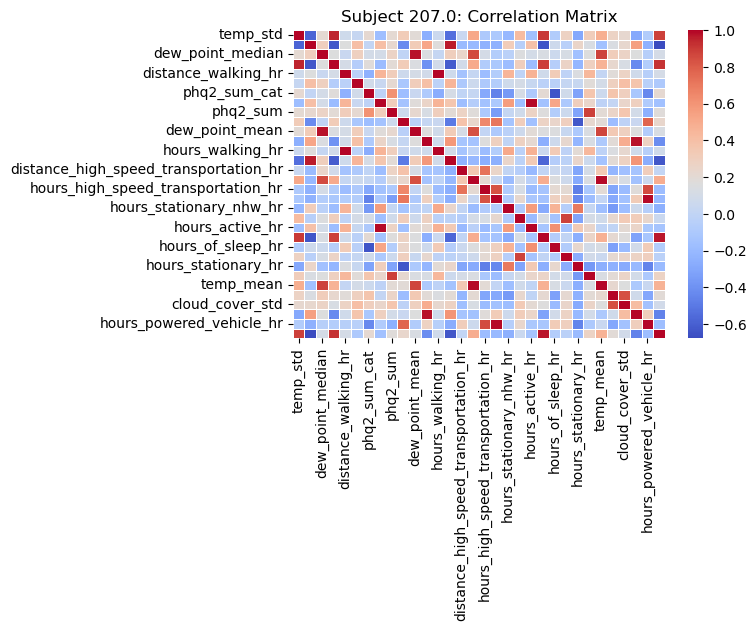

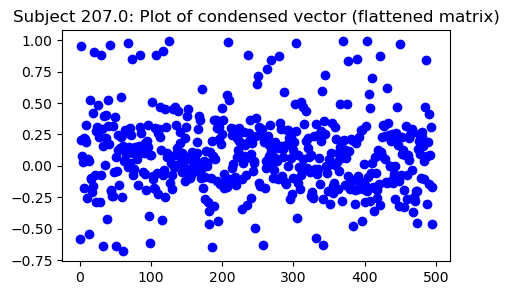

365 subs with symptom matrices
365 filled condensed arrays


DATAFRAME: v1_week
In df there are 251 subjects.


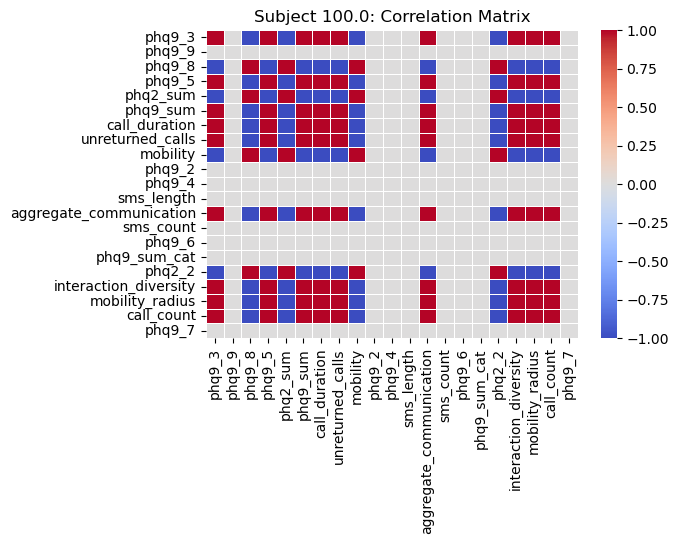

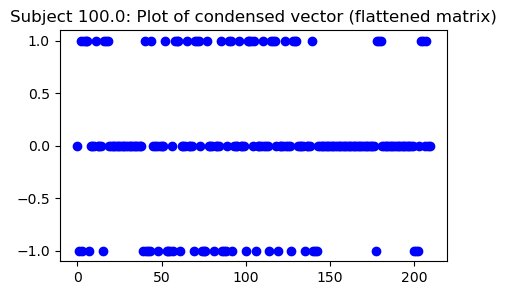

226 subs with symptom matrices
226 filled condensed arrays


DATAFRAME: v2_week
In df there are 222 subjects.


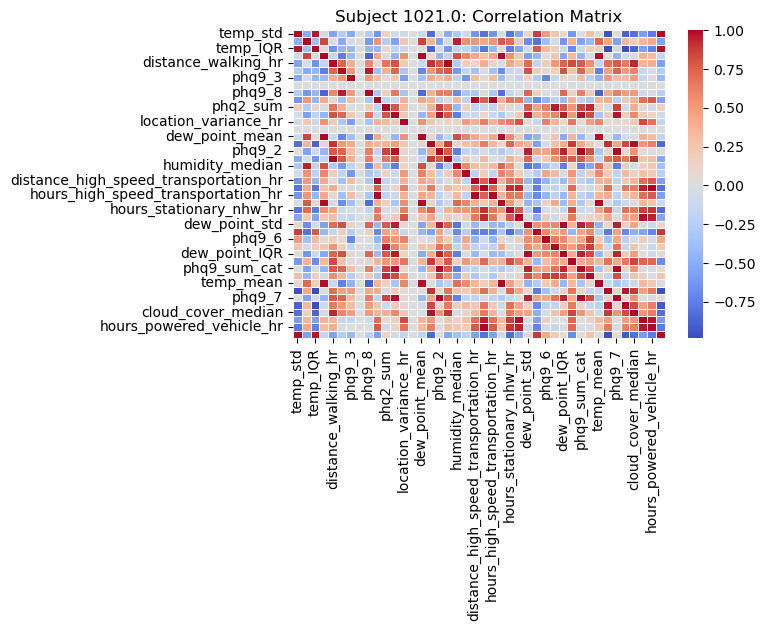

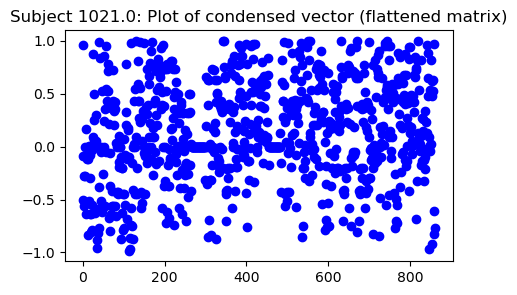

171 subs with symptom matrices
171 filled condensed arrays


In [3]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
demographic_vars = ['gender','education','race','age']                # covariates
target_vars = ['phq9_sum_cat','phq2_sum_cat']

# Create dicts of all subjects' correlation matrices
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  
    df = df.loc[:, ~df.columns.str.contains('_int')]
    print(f'\n\nDATAFRAME: {name}')
    ignore_cols = [col for col in df.columns if col in demographic_vars or col in id_columns]
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1)
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict



/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


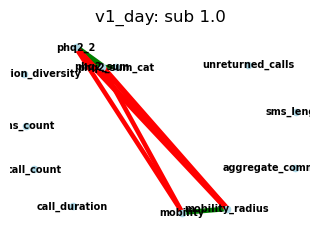

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


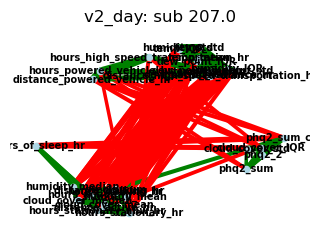

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


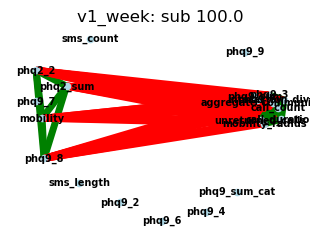

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


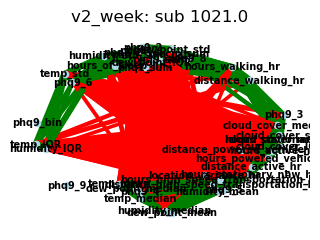

In [4]:
############### Plot individual networks of symptom matrices #################

for name, df_dict in symptom_matrices_df_dict.items():
    count=0
    for sub, corr_matrix in df_dict.items():
        if count<1:
            fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
            count=+1

In [5]:
# Double check where 'labels' are for columns
symptom_matrices_df_dict['v1_day'][list(symptom_matrices_df_dict['v1_day'].keys())[0]].index

Index(['phq2_sum_cat', 'sms_length', 'call_duration', 'phq2_2',
       'unreturned_calls', 'interaction_diversity', 'aggregate_communication',
       'mobility', 'sms_count', 'phq2_sum', 'mobility_radius', 'call_count'],
      dtype='object')

v1_day
(12, 12) variables included


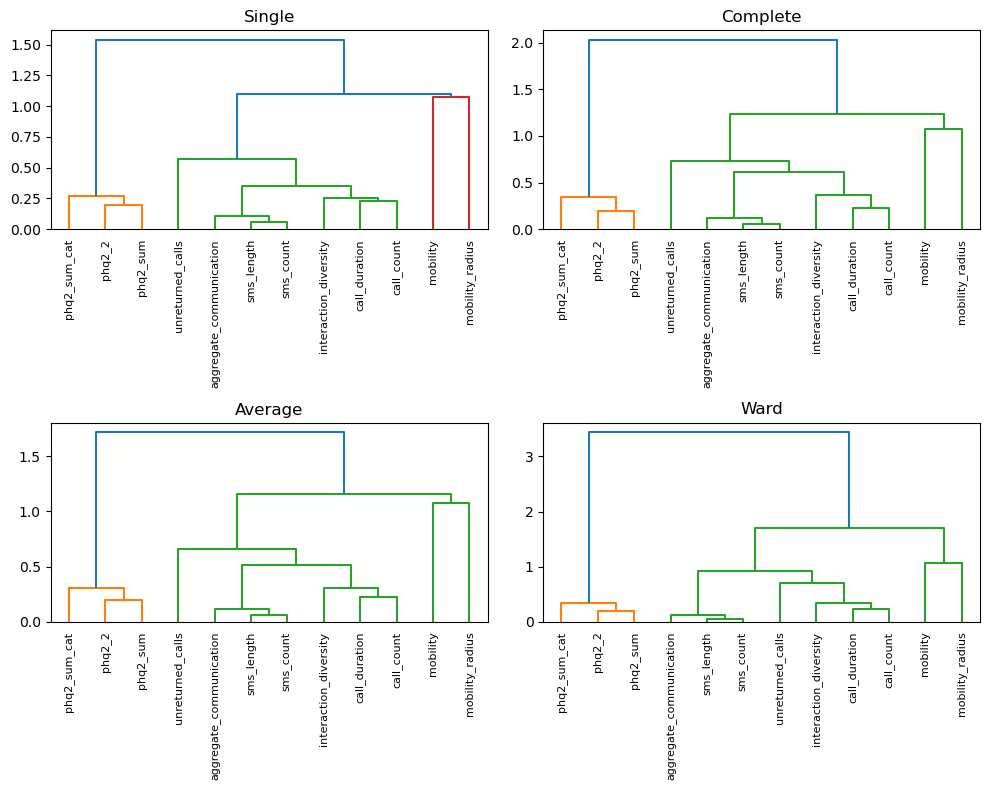

v2_day
(32, 32) variables included


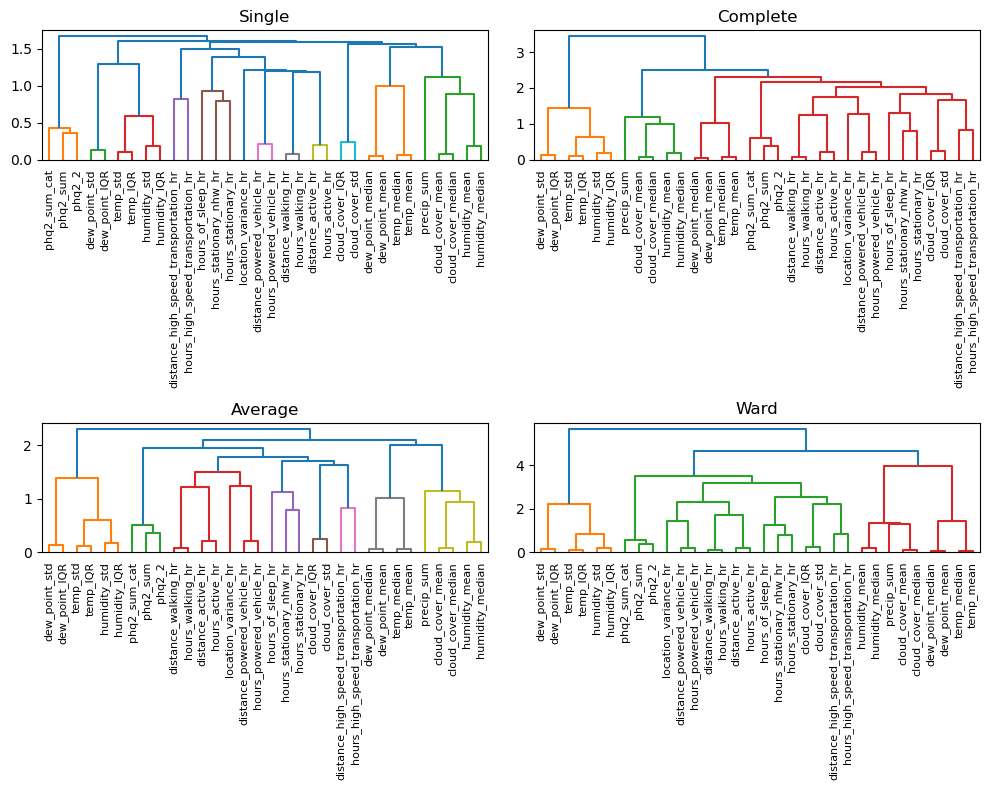

v1_week
(21, 21) variables included


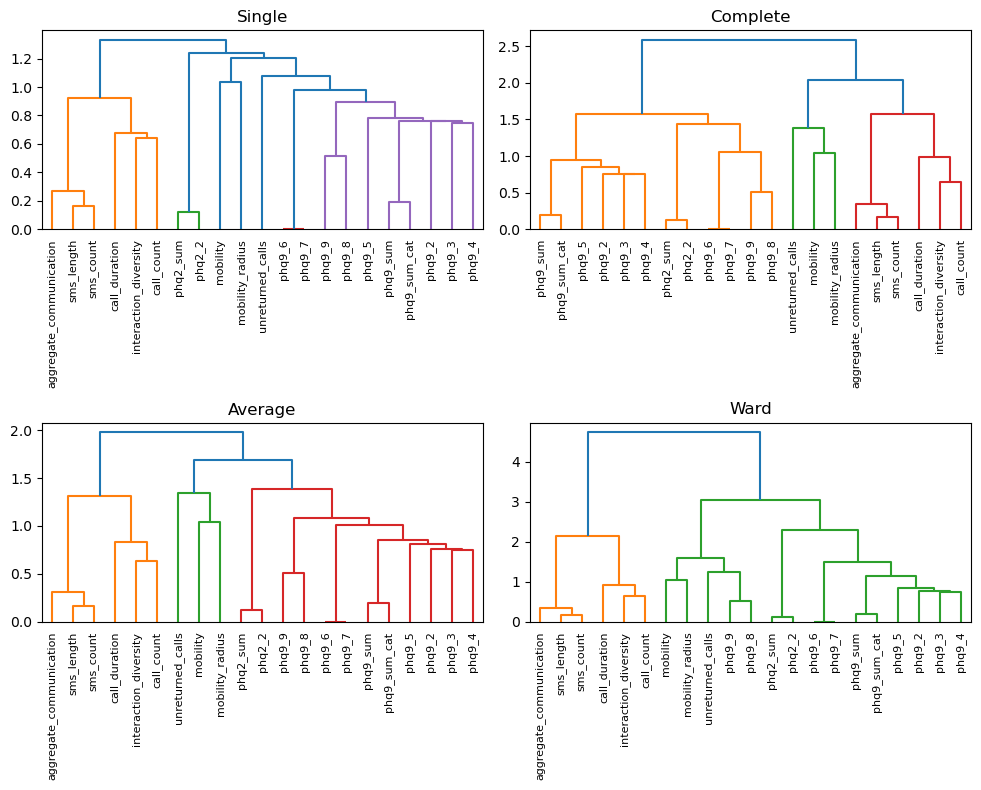

v2_week
(42, 42) variables included


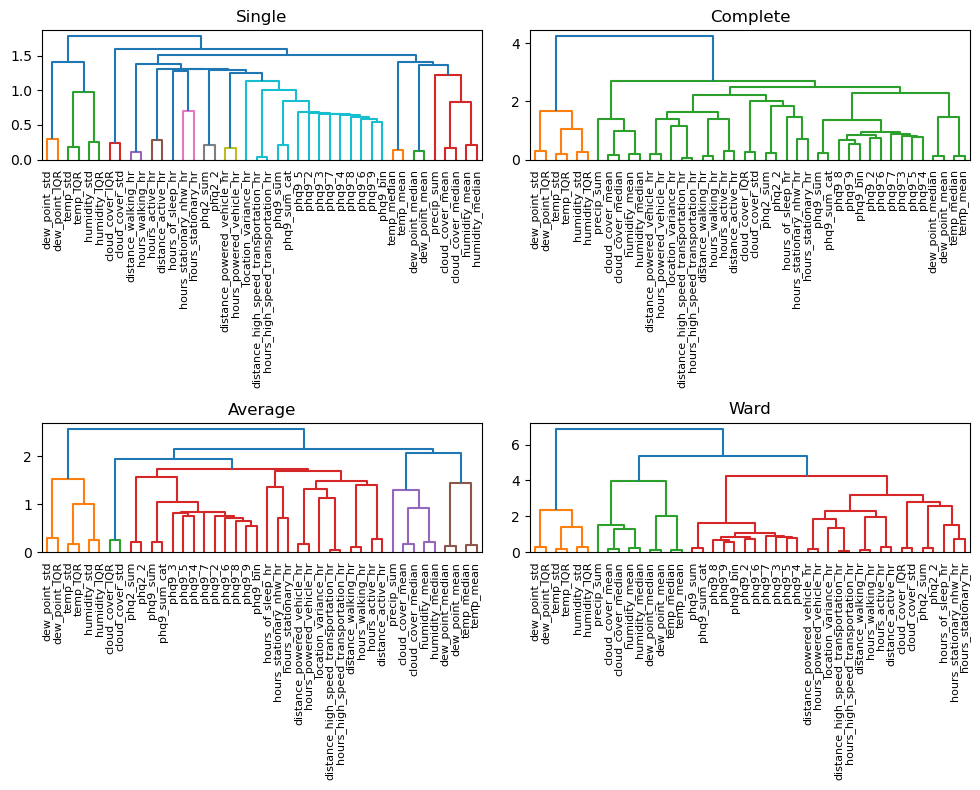

In [6]:
## Plot options
for name, df in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(df)
    fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward


### Mark down best fits:
* v1_day -> 4, average
* v1_week -> 5, average
* v2_day -> 12, single (seems like a lot of noise)  
* v2_week ->

In [7]:
################# Create cluster_dict of Variables + Cluster Labels ############

clust_dict = {}
# clust_dict['v1_day'] = v1_day_clust_dict
for name, dictionary in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(dictionary)
    if 'v1_day' in name:
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=3, linkage='single', is_dict=False)
    if 'v2_day' in name:
       clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=12, linkage='average', is_dict=False)
    if 'v1_week' in name:
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='single', is_dict=False)
    if 'v2_week' in name:
       clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=13, linkage='single', is_dict=False)

In [8]:
################# Create df_pca of Variables + 1st PC of clusters Labels ############

dfs_pca = {}
dfs_pca_dict = {}
for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
    print(f'\nFor {name}')
    dfs_pca[name], dfs_pca_dict[name] = fs.pca_on_clusters(df_scaled, clust_dict[name], n_clusters=13) #n_clusters = number shown, so choose max



For v1_day
Cols for cluster 0: ['mobility_radius', 'mobility']
Cols for cluster 1: ['phq2_2', 'phq2_sum', 'phq2_sum_cat']
Cols for cluster 2: ['sms_count', 'call_count', 'unreturned_calls', 'aggregate_communication', 'interaction_diversity', 'call_duration', 'sms_length']
Skipping cluster 3: No variables assigned.
Skipping cluster 4: No variables assigned.
Skipping cluster 5: No variables assigned.
Skipping cluster 6: No variables assigned.
Skipping cluster 7: No variables assigned.
Skipping cluster 8: No variables assigned.
Skipping cluster 9: No variables assigned.
Skipping cluster 10: No variables assigned.
Skipping cluster 11: No variables assigned.
Skipping cluster 12: No variables assigned.

For v2_day
Cols for cluster 0: ['cloud_cover_mean', 'humidity_mean', 'humidity_median', 'precip_sum', 'cloud_cover_median']
Cols for cluster 1: ['temp_mean', 'dew_point_median', 'dew_point_mean', 'temp_median']
Cols for cluster 2: ['hours_stationary_nhw_hr', 'hours_stationary_hr', 'hours_of_

In [16]:
# # Name the clusters
dfs_pca_dict['v1_day'][0]['name'] = 'pc_mobility'
dfs_pca_dict['v1_day'][1]['name'] = 'pc_depression_phq2'
dfs_pca_dict['v1_day'][2]['name'] = 'pc_communication_volume'

dfs_pca_dict['v2_day'][0]['name'] = 'pc_cloud_humidity_precip'
dfs_pca_dict['v2_day'][1]['name'] = 'pc_temperature_dewpoint'
dfs_pca_dict['v2_day'][2]['name'] = 'pc_stationary_sleep'
dfs_pca_dict['v2_day'][3]['name'] = 'pc_temp_humidity_variability'
dfs_pca_dict['v2_day'][4]['name'] = 'pc_depression_phq2'
dfs_pca_dict['v2_day'][5]['name'] = 'pc_highspeed_transport'
dfs_pca_dict['v2_day'][6]['name'] = 'pc_active_behavior'
dfs_pca_dict['v2_day'][7]['name'] = 'pc_cloud_variability'
dfs_pca_dict['v2_day'][8]['name'] = 'pc_powered_vehicle'
dfs_pca_dict['v2_day'][9]['name'] = 'pc_dewpoint_variability'
dfs_pca_dict['v2_day'][10]['name'] = 'pc_location_variance'
dfs_pca_dict['v2_day'][11]['name'] = 'pc_walking'

dfs_pca_dict['v1_week'][0]['name'] = 'pc_mobility'
dfs_pca_dict['v1_week'][1]['name'] = 'pc_depression_phq9'
dfs_pca_dict['v1_week'][2]['name'] = 'pc_depression_phq2'
dfs_pca_dict['v1_week'][3]['name'] = 'pc_communication_volume'
dfs_pca_dict['v1_week'][4]['name'] = 'pc_unreturned_calls'

dfs_pca_dict['v2_week'][0]['name'] = 'pc_cloud_humidity_precip'
dfs_pca_dict['v2_week'][1]['name'] = 'pc_temp_humidity_variability'
dfs_pca_dict['v2_week'][2]['name'] = 'pc_highspeed_location_depression'
dfs_pca_dict['v2_week'][3]['name'] = 'pc_active_behavior'
dfs_pca_dict['v2_week'][4]['name'] = 'pc_stationary'
dfs_pca_dict['v2_week'][5]['name'] = 'pc_dewpoint_variability'
dfs_pca_dict['v2_week'][6]['name'] = 'pc_walking'
dfs_pca_dict['v2_week'][7]['name'] = 'pc_dewpoint_mean_median'
dfs_pca_dict['v2_week'][8]['name'] = 'pc_temperature_mean_median'
dfs_pca_dict['v2_week'][9]['name'] = 'pc_powered_vehicle'
dfs_pca_dict['v2_week'][10]['name'] = 'pc_depression_phq2'
dfs_pca_dict['v2_week'][11]['name'] = 'pc_sleep'
dfs_pca_dict['v2_week'][12]['name'] = 'pc_cloud_variability'


for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
    dfs_pca[name] = fs.merge_df_via_cluster_pca_dict(df_scaled, dfs_pca_dict[name], on_columns=['num_id', 'dt', 'week'])
    dfs_pca[name].to_csv(os.path.join(brighten_dir, f'{name}_pca.csv'), index=False)




KeyboardInterrupt: 

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


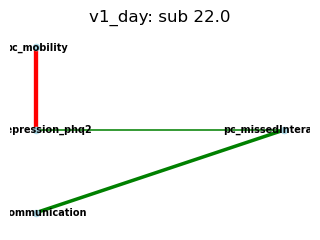

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


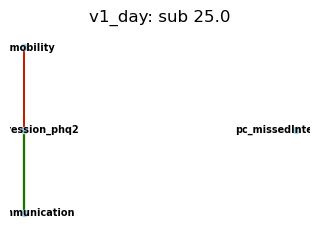

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


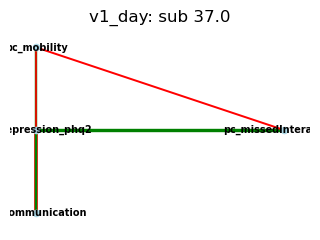

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


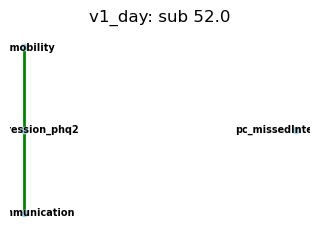

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


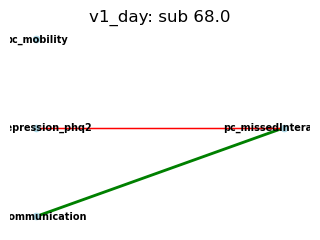

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


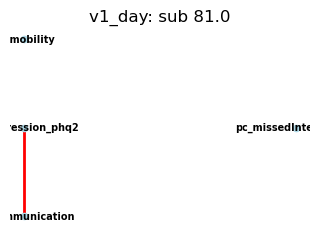

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


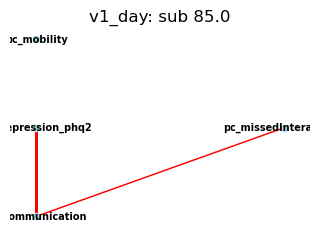

In [55]:
############ Plot subjects' individual networks of PCs ############

# Predefine fixed positions for nodes
fixed_positions_v1_day = {
    'pc_communication': (1, 1),
    'pc_depression_phq2': (1, 2),
    'pc_mobility': (2, 1),
    'pc_mobility': (1, 3),
    'pc_missedInteractions': (2, 2)
}

fixed_positions_v1_week = {
    'pc_depression_phq9': (1, 2),
    'pc_mobility': (1, 1),
    'pc_communication': (2, 1),
    'pc_missedInteractions': (1, 3),
    'pc_depression_phq2': (2, 2)
}


for name, df in dfs_pca.items():
    count, count2 = 0, 0
    
    cols=[col for col in df.columns.to_list() if 'pc_' in col]
    for sub in df['num_id'].unique():
        sub_df = df[df['num_id']==sub]
        if sub_df.shape[0] > 8:
            if count<7:
                if 'v1_day' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1_day)
                    count+=1
            if count2<7:
                if 'v1_week' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1_week)
                    count2+=1


## Checking for collinearity




For v1_day:


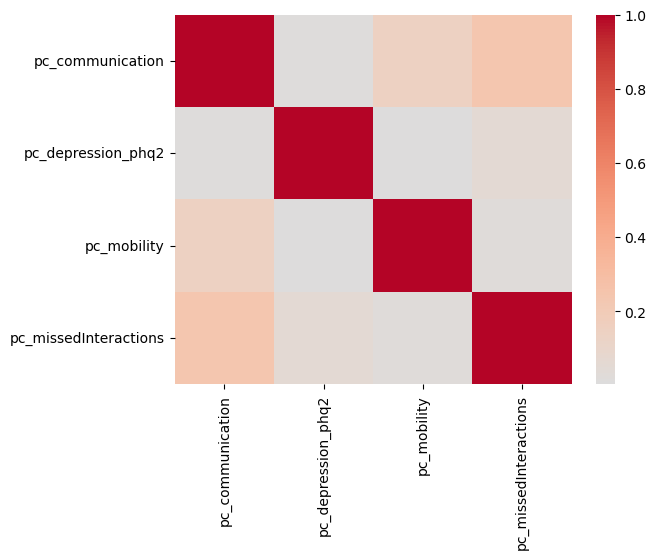



For v2_day:


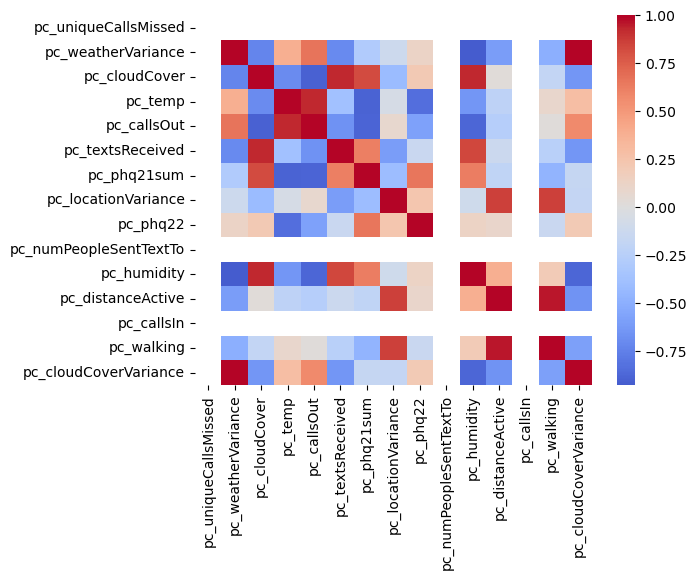



For v1_week:


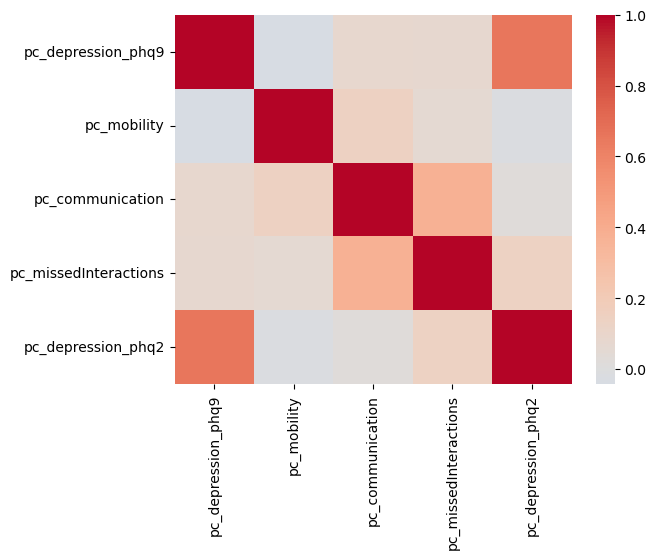

In [56]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if 'pc_' in col]
    sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.show()

We can see that our features are successfull not correlated, except phq2 and phq9, which is expected, and in most cases, phq2 won't be used to predict phq9. 

In [59]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     print('\nInvestigating Kurtosis:')
#     # Calculate kurtosis for numeric columns
#     kurtosis_values = df[numeric_cols].select_dtypes(include='number').apply(lambda x: kurtosis(x, fisher=True))
#     kurtosis_sorted = kurtosis_values.sort_values(ascending=False) # Sort by highest kurtosis
#     print(kurtosis_sorted) #display
    
#     for col in kurtosis_sorted.isna().index:
#         print(f'Kurtosis is NaN for {col}:')
#         print(df[col].nunique())      # Unique values
#         print(df[col].isna().sum())   # Missing values
#         print(df[col].describe())     # Summary stats


In [58]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     print('\nInvestigating skew:')
#     print(df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)) # sort by highest, display    

In [62]:
### Create lag variable
for name in df_names:
    if not 'v2_week' in name:
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
        print(f'\n\nFor {name}:')
        lag = phq9_cols + phq2_cols
        to_lag = [col for col in lag if col in df.columns]
        df_lag = pre.create_lag_variables(df, to_lag)
        display(df.head())
        df_lag.to_csv(os.path.join(brighten_dir, f'{name}_pca_lag.csv'), index=False)
        print(f"Saved {name}_pca_lag.csv to brighten_dir")





For v1_day:

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1, 4441 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 4441 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 4441 rows


,num_id,week,day,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,...,phq2_1,phq2_2,phq2_sum,gender,age,dt,pc_communication,pc_depression_phq2,pc_mobility,pc_missedInteractions
0,9.0,0.0,5.0,-0.101408,0.903113,0.817875,-0.403863,1.664963,2.143261,2.038182,...,0.047157,0.055051,0.074677,1.656042,1.198991,2014-08-05,0.430650,0.124544,2.988437,1.698763
1,21.0,5.0,38.0,-1.871791,-1.090528,1.171137,-1.261801,-0.969375,2.401586,-1.072055,...,0.047157,0.055051,0.074677,-0.603849,0.024184,2014-09-21,-2.145318,0.124544,0.954763,-0.935575
2,21.0,6.0,44.0,0.203317,-1.090528,-0.689211,-1.261801,0.165173,-1.323033,0.000094,...,0.047157,0.834697,0.503827,-0.603849,0.024184,2014-09-27,0.696140,-0.156898,2.341276,0.198973
3,21.0,6.0,45.0,-1.118921,-1.949143,-2.727026,-0.778635,0.165173,1.766444,-0.231338,...,0.841233,0.834697,0.866667,-0.603849,0.024184,2014-09-28,0.229052,-1.851312,1.438345,-0.935575
4,21.0,6.0,48.0,-0.503022,-1.090528,0.303073,-0.403863,0.165173,2.597840,0.915940,...,0.841233,0.834697,0.866667,-0.603849,0.024184,2014-10-01,-2.045442,-0.812494,1.042863,-0.935575


Saved v1_day_pca_lag.csv to brighten_dir


For v2_day:

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1, 4 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 4 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 4 rows


,num_id,week,day,distance_walking_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_walking_hr,...,pc_textsReceived,pc_phq21sum,pc_locationVariance,pc_phq22,pc_numPeopleSentTextTo,pc_humidity,pc_distanceActive,pc_callsIn,pc_walking,pc_cloudCoverVariance
0,302.0,4.0,34.0,-1.547787,-1.521772,0.0,0.0,0.0,0.0,-0.984936,...,-0.457447,1.053083,0.575122,1.189696,0.0,0.023887,0.585413,-0.668577,0.159738,0.966158
1,302.0,5.0,37.0,0.683510,0.338784,0.0,0.0,0.0,0.0,0.048904,...,0.879492,0.429588,-0.267267,-0.477751,0.0,1.172869,0.751238,-0.668577,0.869974,-1.304551
2,302.0,5.0,39.0,0.372524,0.783584,0.0,0.0,0.0,0.0,-0.254659,...,-1.111969,-2.107601,1.411791,-0.477751,0.0,-0.764070,1.558127,-0.668577,2.681763,0.372278
3,302.0,6.0,44.0,-1.547787,-1.521772,0.0,0.0,0.0,0.0,-0.984936,...,-0.406451,-0.653866,-0.817254,-0.477751,0.0,-1.128003,-1.250529,-0.668577,-1.507738,2.074954


Saved v2_day_pca_lag.csv to brighten_dir


For v1_week:

 Adding lag of -1 to column: phq9_1 -> phq9_1_lag-1, 660 rows

 Adding lag of -1 to column: phq9_2 -> phq9_2_lag-1, 660 rows

 Adding lag of -1 to column: phq9_3 -> phq9_3_lag-1, 660 rows

 Adding lag of -1 to column: phq9_4 -> phq9_4_lag-1, 660 rows

 Adding lag of -1 to column: phq9_5 -> phq9_5_lag-1, 660 rows

 Adding lag of -1 to column: phq9_6 -> phq9_6_lag-1, 660 rows

 Adding lag of -1 to column: phq9_7 -> phq9_7_lag-1, 660 rows

 Adding lag of -1 to column: phq9_sum -> phq9_sum_lag-1, 660 rows

 Adding lag of -1 to column: phq9_bin -> phq9_bin_lag-1, 660 rows

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1, 660 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 660 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 660 rows


,num_id,week,day,aggregate_communication,call_count,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,...,phq9_sum,phq9_bin,gender,age,dt,pc_depression_phq9,pc_mobility,pc_communication,pc_missedInteractions,pc_depression_phq2
0,21.0,10.0,71.5,-0.307222,-0.951653,-1.052668,-0.491618,-1.922677,-0.844628,-0.079512,...,0.484128,1.303537,-0.607847,0.047498,2014-10-23,1.967172,-1.914832,-1.028104,-0.529798,-0.067865
1,22.0,6.0,45.0,1.121347,-0.768855,-0.231999,-1.084741,1.206361,0.807768,1.197651,...,0.484128,1.303537,-0.607847,-1.467091,2014-09-25,1.862868,-1.065598,1.181097,1.506363,-0.067865
2,22.0,8.0,59.0,0.810392,-0.213791,-0.231999,-1.375991,-0.259382,0.046046,0.900872,...,0.360830,-0.767144,-0.607847,-1.467091,2014-10-09,0.384178,0.105706,2.221940,-0.432970,0.246235
3,25.0,10.0,73.0,0.823721,0.180032,0.167011,1.218648,-0.302232,-1.224821,0.891035,...,0.700237,1.303537,-0.607847,-0.775707,2014-10-27,2.856716,-0.251425,1.604953,2.087495,1.823008
4,25.0,12.0,87.0,0.875321,1.781806,1.056433,0.135854,0.330737,-0.208479,0.728100,...,0.224530,-0.767144,-0.607847,-0.775707,2014-11-10,0.384178,-0.217799,1.015818,0.665577,0.068329


Saved v1_week_pca_lag.csv to brighten_dir




FOR v1_day
(4441, 24)


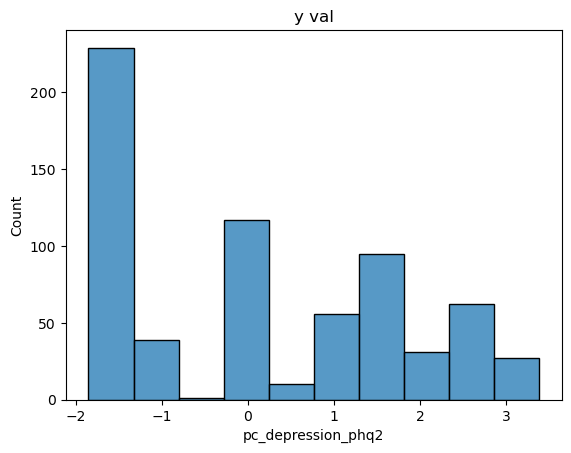

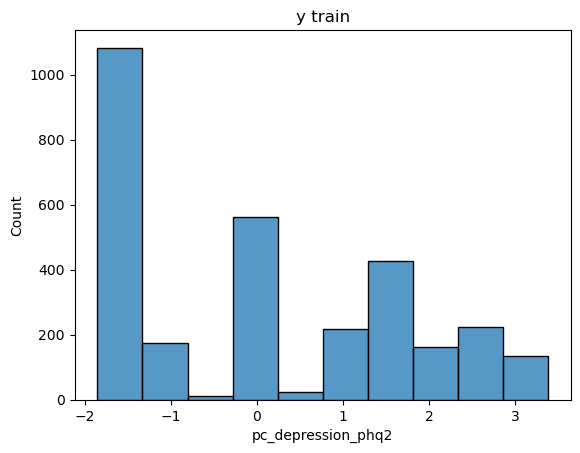

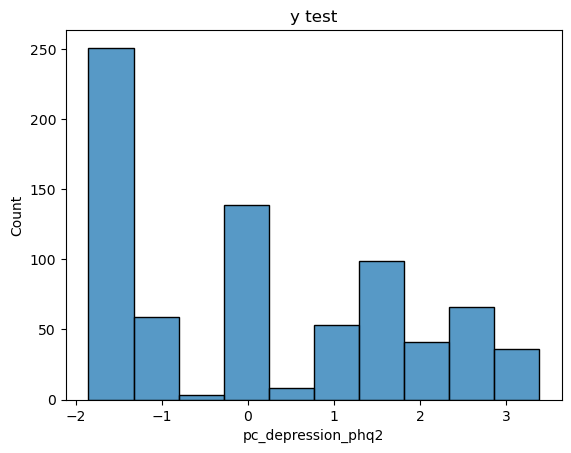



FOR v2_day
(4, 65)
phq2_sum not in v2_day


In [ ]:
from sklearn.model_selection import train_test_split

for name in df_names:
    if 'v1_day' in name:
        print(f"\n\nFOR {name}")
        data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca_lag.csv'))
        print(data_df.shape)
        if not data_df.empty:
            if 'pc_depression_phq2' in data_df.columns:
                X = data_df.drop(columns=[col for col in data_df.columns if 'pc_' not in col] + ['pc_depression_phq2']).copy()
                y = data_df['pc_depression_phq2'].copy()
                
                # Create train/test split
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
                X_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_val.csv'))
                y_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_val.csv'))
                
                X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
                X_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_train.csv'))
                y_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_train.csv'))
                X_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_test.csv'))
                y_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_test.csv'))


                # Create hisogram for target value
                sns.histplot(y_val, bins=10)
                plt.title('y val')
                plt.show()

                # Create hisogram for target value
                sns.histplot(y_train, bins=10)
                plt.title('y train')
                plt.show()

                # Create hisogram for target value
                sns.histplot(y_test, bins=10)
                plt.title('y test')
                plt.show()


            else:
                print(f'pc_depression_phq2 not in {name}')



FOR v1_week
(660, 43)


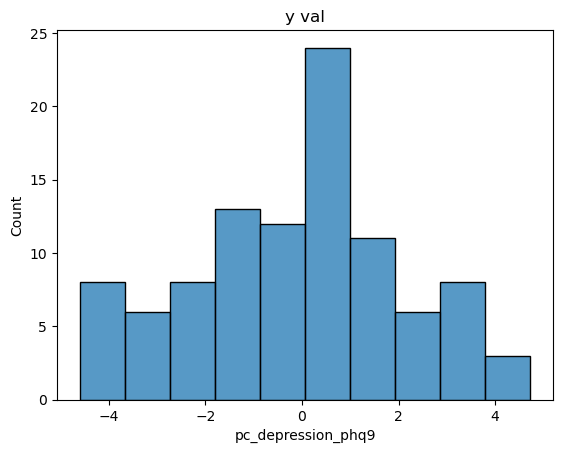

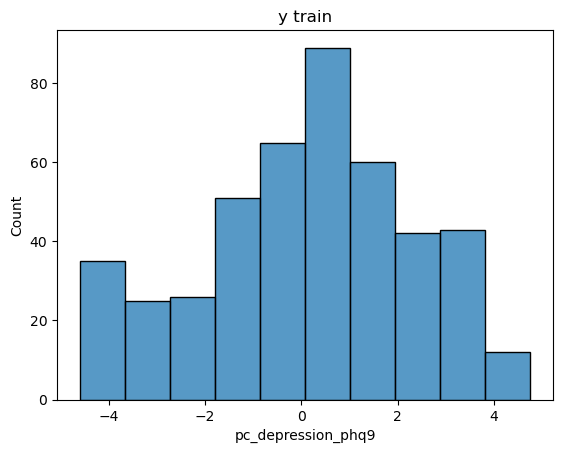

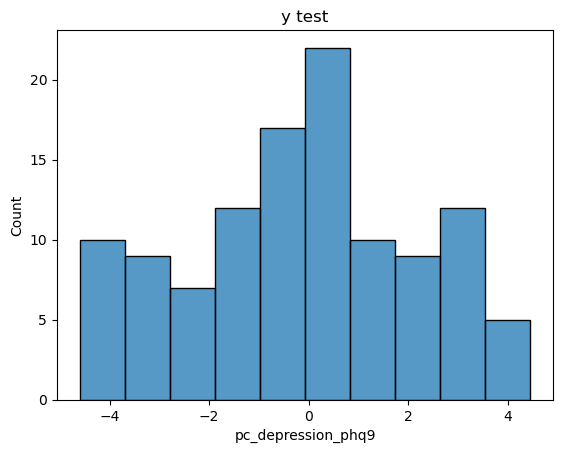

In [64]:
from sklearn.model_selection import train_test_split

for name in df_names:
    if 'v1_week' in name:
        print(f"\n\nFOR {name}")
        data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca_lag.csv'))
        print(data_df.shape)
        if not data_df.empty:
            if 'pc_depression_phq9' in data_df.columns:
                X = data_df.drop(columns=[col for col in data_df.columns if 'pc_' not in col] + ['pc_depression_phq2','pc_depression_phq9']).copy()
                y = data_df['pc_depression_phq9'].copy()
                
                # Create train/test split
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
                X_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_val.csv'))
                y_val.to_csv(os.path.join(brighten_dir, f'{name}_y_val.csv'))
                
                X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
                X_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_train.csv'))
                y_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_train.csv'))
                X_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_test.csv'))
                y_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_test.csv'))


                # Create hisogram for target value
                sns.histplot(y_val, bins=10)
                plt.title('y val')
                plt.show()

                # Create hisogram for target value
                sns.histplot(y_train, bins=10)
                plt.title('y train')
                plt.show()

                # Create hisogram for target value
                sns.histplot(y_test, bins=10)
                plt.title('y test')
                plt.show()


            else:
                print(f'phq2_sum not in {name}')